**SECTION 2.0**

In [64]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
import warnings
from src.utils import nlp_utils
from src.utils import data_utils
import importlib
importlib.reload(nlp_utils)

<module 'src.utils.nlp_utils' from 'c:\\Users\\andre\\OneDrive\\Documents\\EPFL-DESKTOP-0FFTIDB\\AppliedDataAnalysis\\Main\\Project\\ada-2024-project-kjaaanalytics\\src\\utils\\nlp_utils.py'>

In [12]:
# User defined variables
USE_PREPROCESSED_DATA_CSV = True # Set to True to use preprocessed data file, False to preprocess data locally
USE_DOWNSAMPLED_DATA_CSV = False # Set to True to create a downsampled data file, False to create the file locally
USE_DOWNSAMPLED_DATA = True # Set to True to use the downsampled data, False to use the full data

# File paths
PROJECT_FOLDER_FID = '../'
CLEANED_FID = PROJECT_FOLDER_FID+'cleaned_ratings.csv'
PREPROCESSED_FID = PROJECT_FOLDER_FID+'preprocessed_ratings.csv'
DOWNSAMPLED_FID = PROJECT_FOLDER_FID+'downsampled_preprocessed_ratings.csv'

**2.1 Load the Dataframe**

In [6]:
rawdata = pd.read_csv(CLEANED_FID, low_memory=False)

**2.2 Preprocess the Data**

In [11]:
if USE_PREPROCESSED_DATA_CSV:
    rawdata = pd.read_csv(PREPROCESSED_FID, low_memory=False)

    # Drop rows with Nan values in the 'preprocessed text' column
    rawdata = rawdata.dropna(subset=['preprocessed text'])
else:
    # Apply the preprocess_text function to execute text preprocessing steps
    rawdata['preprocessed text'] = rawdata['text'].apply(nlp_utils.preprocess_text)

    # Drop rows with Nan values in the 'preprocessed text' column
    rawdata = rawdata.dropna(subset=['preprocessed text'])

    # Save the preprocessed text to a new CSV file
    rawdata.to_csv(PREPROCESSED_FID, index=False)

# display(rawdata['preprocessed text'][1][1:100])

In [14]:
if USE_DOWNSAMPLED_DATA_CSV:
    downsampled_df = pd.read_csv(DOWNSAMPLED_FID, low_memory=False)
else:
    # Create randomly downsampled data for testing
    downsampled_df = rawdata.sample(frac=0.1, random_state=42)

    # Save the downsampled data to a new CSV file
    downsampled_df.to_csv(DOWNSAMPLED_FID, index=False)

**2.3 Visualization of All Text Data**

In [15]:
if USE_DOWNSAMPLED_DATA:
    df = pd.read_csv(DOWNSAMPLED_FID, low_memory=False)
else:
    df = pd.read_csv(PREPROCESSED_FID, low_memory=False)

Text(0.5, 1.0, 'Wordcloud All Reviews')

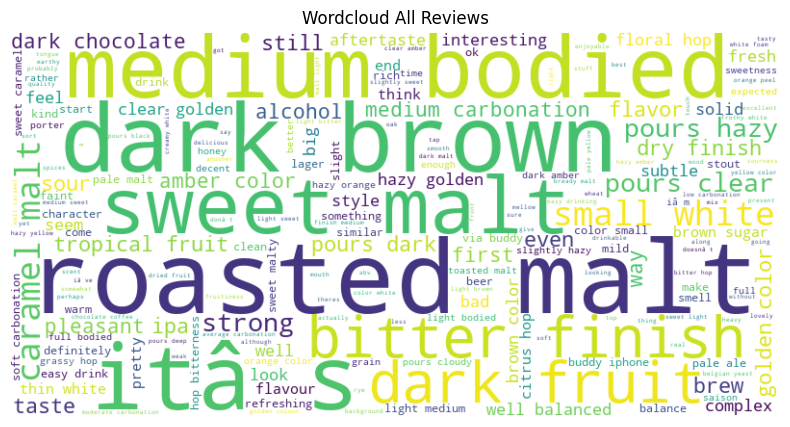

In [16]:
# Plot the wordcloud for all reviews
nlp_utils.plot_wordcloud(df['preprocessed text'].tolist())
plt.title('Wordcloud All Reviews')

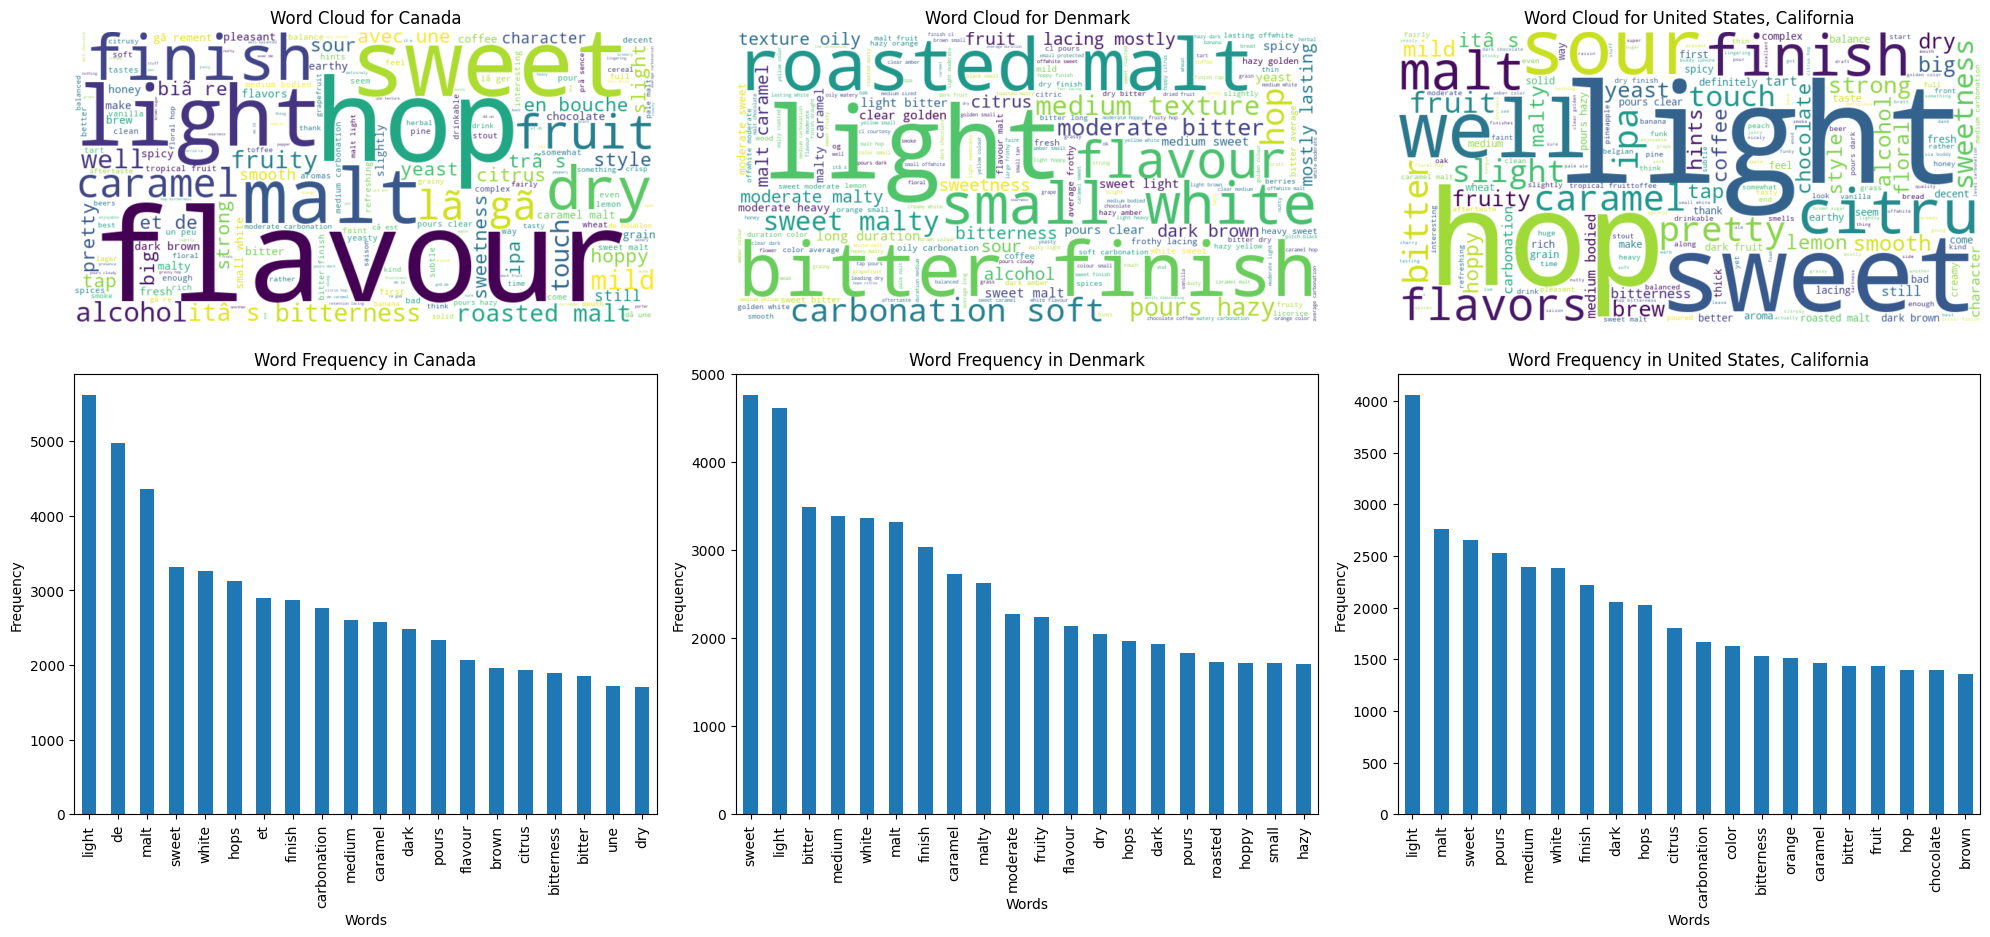

In [18]:
# Find the top 3 countries with the most users and plot the most words used in the reviews
top_countries = df['location_user'].value_counts().head(3).index.tolist()

# Filter the data for the top 3 countries
top_countries_data = df[df['location_user'].isin(top_countries)]

# Plot word clouds for each of the top 3 countries
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, country in enumerate(top_countries):
    country_data = top_countries_data[top_countries_data['location_user'] == country]
    country_text = ' '.join(country_data['preprocessed text'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(country_text)
    
    # Plot word cloud
    axes[0, i].imshow(wordcloud, interpolation='bilinear')
    axes[0, i].set_title(f'Word Cloud for {country}')
    axes[0, i].axis('off')
    
    # Plot histogram
    words = country_text.split()
    word_freq = pd.Series(words).value_counts().head(20)
    word_freq.plot(kind='bar', ax=axes[1, i])
    axes[1, i].set_title(f'Word Frequency in {country}')
    axes[1, i].set_xlabel('Words')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**2.4 Sentiment Analysis**

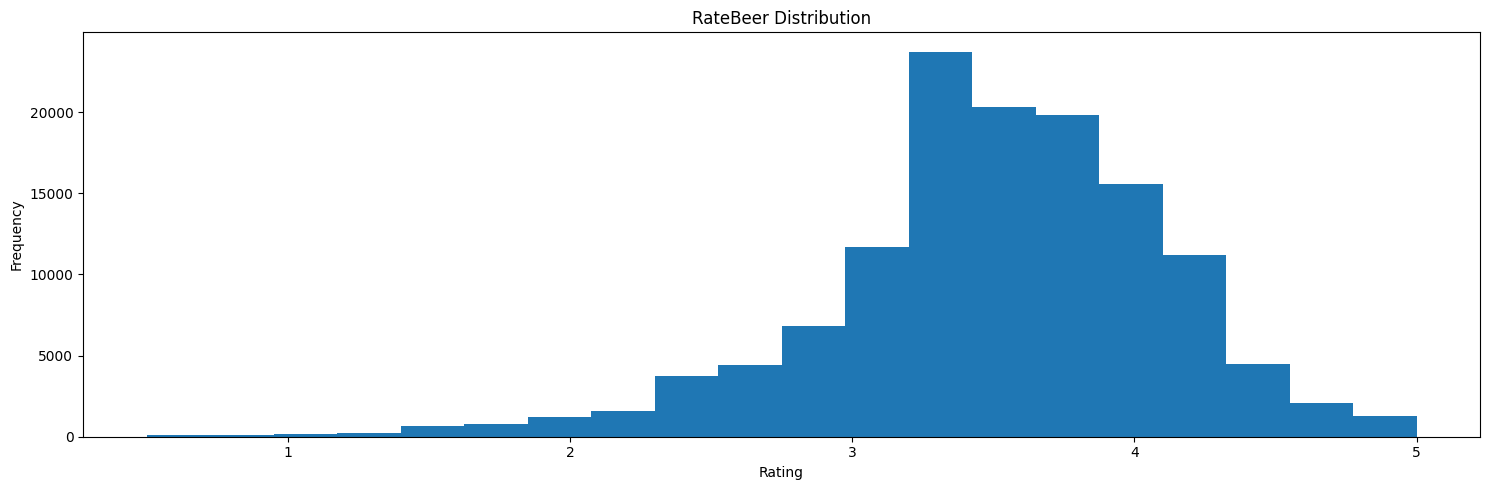

In [20]:
# Plot the distribution of ratings
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
df['rating'].astype(float).plot(kind='hist', bins=20, ax=axes)
axes.set_title('RateBeer Distribution')
axes.set_xlabel('Rating')
axes.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

2.4.1 Based on the rating distribution we can set boundaries for loved, neutral, and disliked beer.

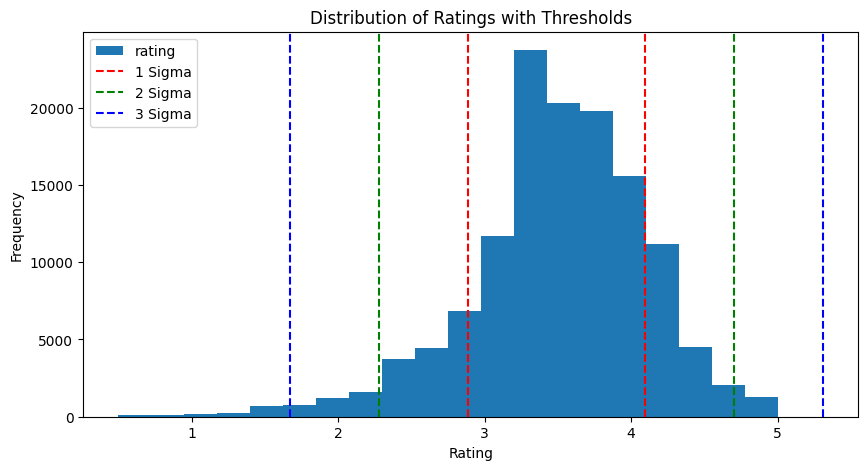

In [21]:
# Determine disliked, neutral, and liked thresholds based on the distribution of ratings

# Sort the ratings in ascending order
sorted_ratings = df['rating'].sort_values()

# Calculate the 1 2 and 3 sigma thresholds
sd = sorted_ratings.std()
avg = sorted_ratings.mean()
one_sigma = avg + sd
two_sigma = avg + 2 * sd
three_sigma = avg + 3 * sd
minus_one_sigma = avg - sd
minus_two_sigma = avg - 2 * sd
minus_three_sigma = avg - 3 * sd

# Plot these thresholds on the distribution of ratings
fig, ax = plt.subplots(figsize=(10, 5))
df['rating'].plot(kind='hist', bins=20, ax=ax)
ax.axvline(one_sigma, color='r', linestyle='--', label='1 Sigma')
ax.axvline(two_sigma, color='g', linestyle='--', label='2 Sigma')
ax.axvline(three_sigma, color='b', linestyle='--', label='3 Sigma')
ax.axvline(minus_one_sigma, color='r', linestyle='--')
ax.axvline(minus_two_sigma, color='g', linestyle='--')
ax.axvline(minus_three_sigma, color='b', linestyle='--')
ax.set_title('Distribution of Ratings with Thresholds')
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

2.4.2 Calculate standard deviation distribution on beer ratings for classifying polarizing beers.

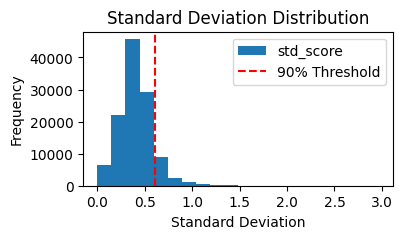

In [23]:
# Add an average score, standard deviation and number of ratings column to the data frame for each beer
df['avg_score'] = df.groupby('beer_name')['rating'].transform('mean')
df['std_score'] = df.groupby('beer_name')['rating'].transform('std')
df['num_ratings'] = df.groupby('beer_name')['rating'].transform('count')

# Top 90% of standard deviation scores
too_high_std = df['std_score'].quantile(0.9)

# Plot the standard deviation distribution 
fig, ax = plt.subplots(figsize=(4, 2))
df['std_score'].plot(kind='hist', bins=20, ax=ax)
ax.axvline(too_high_std, color='r', linestyle='--', label='90% Threshold')
ax.set_title('Standard Deviation Distribution')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

We can define resonable threshholds dynamically.

In [51]:
# Define each beer as liked, neutral, disliked and polarizing based on the thresholds
liked_threshold = one_sigma
disliked_threshold = minus_one_sigma
polarizing_threshold = too_high_std
significant_number_of_ratings = 2 # Minimum number of ratings for a beer to be considered

2.4.3 Categorize all beers as Liked, Disliked, Neutral, or Polarizing

In [65]:
# Categorize all of the beers based on their ratings
df['rating_label'] = df.apply(nlp_utils.apply_rating, axis=1, args=(liked_threshold, disliked_threshold, polarizing_threshold))

2.4.4 Categorize all beers as above by country for geographical comparison.

In [59]:
# Categorize the beers based on their ratings for every country
df = nlp_utils.calculate_ratings_by_country(df, significant_number_of_ratings,liked_threshold, disliked_threshold)

**2.4.5 SHOW RESULTS OF RULES BASED SENTIMENT ANALYSIS**

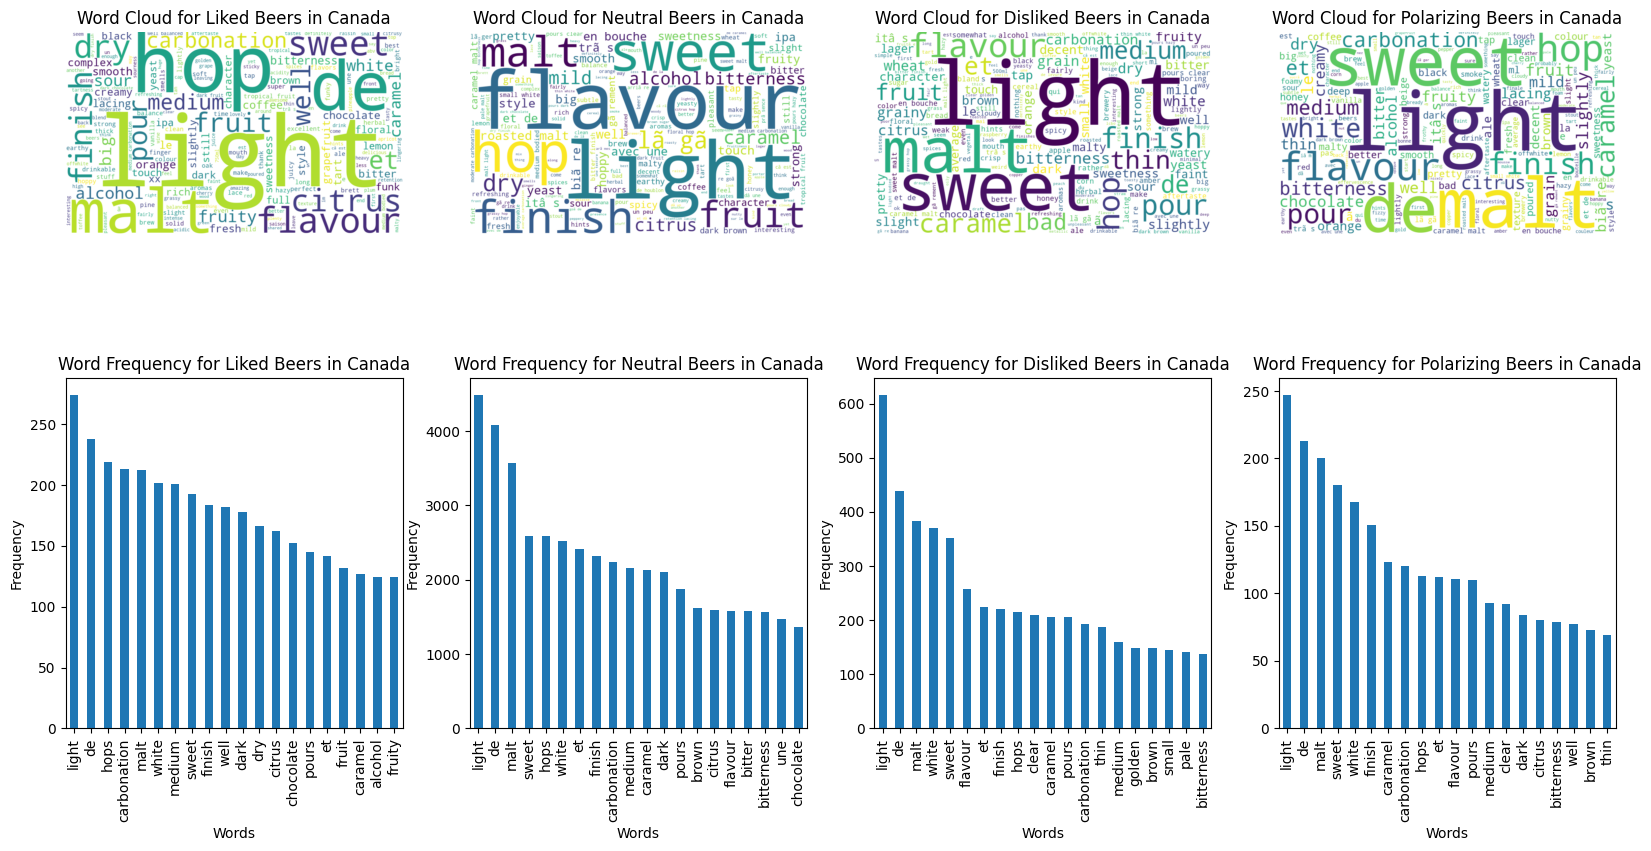

c:\Users\andre\OneDrive\Documents\EPFL-DESKTOP-0FFTIDB\AppliedDataAnalysis\Main\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\andre\OneDrive\Documents\EPFL-DESKTOP-0FFTIDB\AppliedDataAnalysis\Main\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 153 (\x99) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


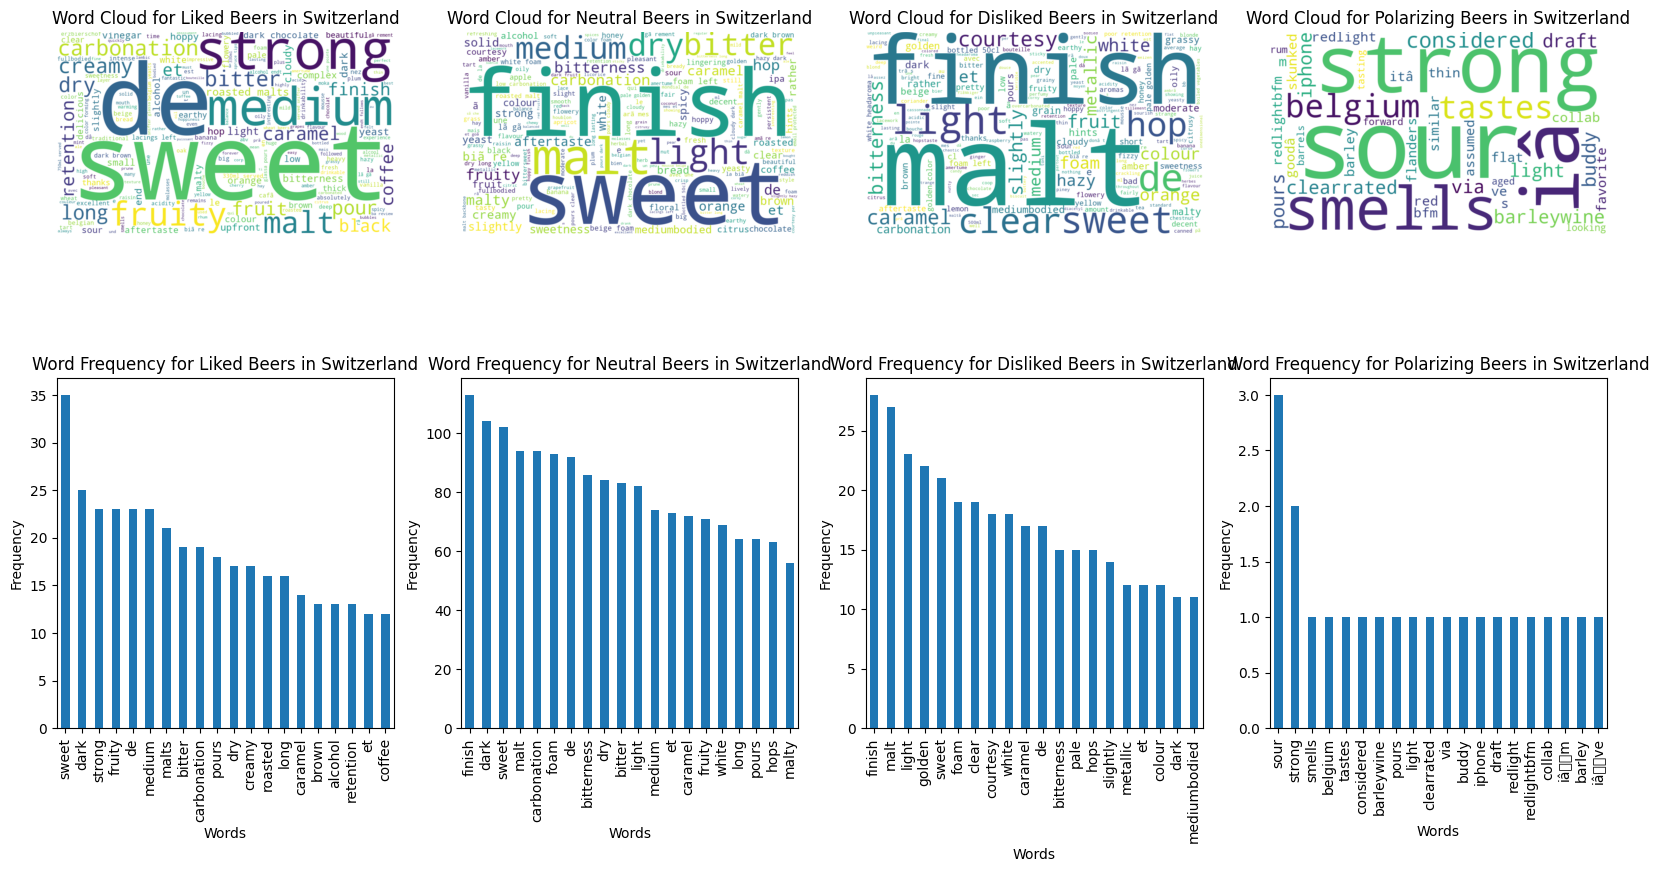

In [62]:
# Plot the word frequencies and word clouds for liked, neutral, and disliked beers in Swizerland and Canada
nlp_utils.plot_country_wordclouds(df, 'Canada')
nlp_utils.plot_country_wordclouds(df, 'Switzerland')
